# Handle Financial Data For Machine Learning

In this notebook we explain various ways of handling financial timeseries data. If you have a data science project involving timeseries, this notebook might help you at handling this particular kind of data. Indeed, when it comes to training machine learning models, the data should be handled decently to make the training process easy and fast.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load the data.

In [2]:
# Dataset parameters.
PATH = "dataset"
SYMBOL = "btcusdt"
DATASET = "ohlc"
PERIOD = 3600
FILENAME_TR = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "train")
FILENAME_TE = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "test")

In [3]:
def load(path, filename):
    """Load the filename as pandas DataFrame.
    """
    df = pd.read_csv(path + "/" + filename)
    df = df.set_index("time")
    df.index = pd.to_datetime(df.index)
    return df

In [4]:
df_tr = load(PATH, FILENAME_TR)
df_te = load(PATH, FILENAME_TE)

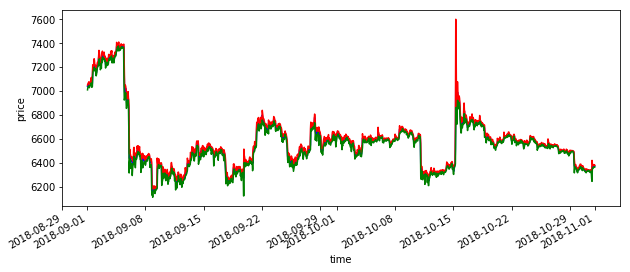

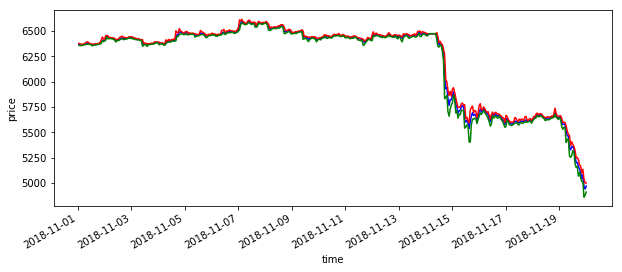

In [5]:
# Display the training dataset.
plt.figure(figsize=(10,4))
plt.plot(df_tr.index.values, df_tr["avg"].values, color="b")
plt.plot(df_tr.index.values, df_tr["high"].values, color="r")
plt.plot(df_tr.index.values, df_tr["low"].values, color="g")
plt.xlabel("time")
plt.ylabel("price")
plt.gcf().autofmt_xdate()
plt.show()

# Display the test dataset.
plt.figure(figsize=(10,4))
plt.plot(df_te.index.values, df_te["avg"].values, color="b")
plt.plot(df_te.index.values, df_te["high"].values, color="r")
plt.plot(df_te.index.values, df_te["low"].values, color="g")
plt.xlabel("time")
plt.ylabel("price")
plt.gcf().autofmt_xdate()
plt.show()

## 2. Normalisation methods.

We have a dataset $X \in \mathbb{R}^{T \times n}$ where $T$ is the length of the timeseries we loaded. In order to train a machine learning algorithm, we have to draw samples from the given data. So we have to extract as many samples as possible from the given dataset, i.e. timeseries with a shorter length that we will call $lk$. In order the build a dataset,

$$
X = [ X_1, X_2, ..., X_m]
$$

where $m \in \mathbb{N}$ and $X_i \in \mathbb{R}^{N \times n}$ 

Once this step has been performed, we will have to normalise the timeseries.

### A. Windowing.

### B. Pivot method.

For a timeseries given as

$$
x = [x_1, x_2, ..., x_N]
$$

where,

$$ N \in \mathbb{N}$$

The pivot method normalisation method is computed as follows

$$ 
z_{t} = 100 ( \frac{x_{t}}{x_{0}} - 1 ) 
\; \text{where} \;
t \in  [1, N]
$$


In [6]:
def normalise_pvt(df, lookback, log=False):
    """Normalise the timeseries df with the pivot method.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    eps = 1.0E-8
    data = []
    for k in range(lookback):
        s = lookback - k - 1
        if log is False:
            dfs = 100 * ( df.shift(s) / ( df + eps ) - 1.0 )
        else:
            dfs = 100 * ( np.log(df.shift(s)) - np.log(df) )
        data.append(dfs)
    return pd.concat(data, axis=1)

### C. Percentage change method

For a timeseries given as

$$
x = [x_1, x_2, ..., x_N]
$$

where,

$$ N \in \mathbb{N}$$

The percentage change normalisation method is computed as follows,

$$ 
z_{t} = 100 ( \frac{x_{t}}{x_{t-1}} - 1 ) 
\; \text{where} \;
t \in  [1, N]
$$



In [7]:
def normalise_pct(df, lookback, log=False):
    """Normalise the timeseries df with the pct method.
    
    :param df: the timeseries.
    :type df: pandas dataframe.
    :param lookback: the lookback horizon.
    :type lookback: int.
    """
    eps = 1.0E-8
    data = []
    for k in range(lookback):
        s = lookback -k - 1
        if log is False:
            dfs = 100 * ( df.shift(s) / ( df.shift(s+1) + eps ) - 1.0 )
        else:
            dfs = 100 * ( np.log( df.shift(s) / ( df.shift(s+1) + eps)))
        data.append(dfs)
    return pd.concat(data, axis=1)

## 3. Visualisation

We can now visualise the result of the normalisation method.

In [13]:
# Set the lookback horizon.
LK = 8

# Compute the pivot normalised timeseries.
data_pvt = normalise_pct(df_te, LK).values
data_pvt = data_pvt.reshape(data_pvt.shape[0], LK, -1)

# Compute the percetange change normalised timeseries.
data_pct = normalise_pct(df_te, LK*2).values
data_pct = data_pct.reshape(data_pct.shape[0], LK, -1)

/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


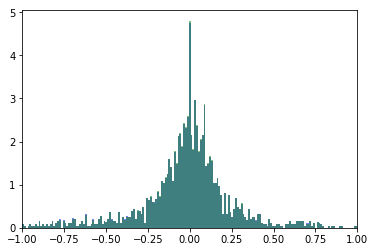

In [14]:
# Visualise.
plt.figure()
hista = plt.hist(data_pvt.reshape(-1,1), 1000, density=True, facecolor="b", alpha=0.50)
histb = plt.hist(data_pct.reshape(-1,1), 1000, density=True, facecolor="g", alpha=0.50)
plt.xlim([-1, 1])
plt.show()